# Lab 1: language modeling
__Author : Benjamin Ternot__

In [1]:
from IPython.display import display, HTML

def display_answer(title, answer):
    if isinstance(answer, list):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1><ul>"""
        for a in answer:
            string_display += f"<li>{a}</li>"
        string_display += "</ul></div>"
    elif isinstance(answer, str):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1>{answer} </div>"""
    else:
        raise ValueError("Answer should be a string or a list of strings.")
    display(HTML(string_display))

In [2]:
# Cell A
# load data
import os
github_path = "https://raw.githubusercontent.com/najoungkim/COGS/main/data"
data = {}
for name in ['train', 'dev', 'test', 'gen']:
    url = os.path.join(github_path, '{}.tsv'.format(name))
    filepath = '{}.tsv'.format(name)
    if not os.path.isfile(filepath):
        os.system('wget {}'.format(url))
    assert os.path.isfile(filepath)
    lines = open(filepath, 'r')
    lines = map(lambda x: x.strip(), lines)
    lines = map(lambda x: x.split('\t')[0], lines)
    data[name] = list(lines)

# look at the data
for name in ['train', 'dev', 'test', 'gen']:
    print('=== {} ({} sentences)==='.format(name.upper(), len(data[name])))
    print('\n'.join(data[name][:10]))

=== TRAIN (24155 sentences)===
A rose was helped by a dog .
The sailor dusted a boy .
Emma rolled a teacher .
Evelyn rolled the girl .
A cake was forwarded to Levi by Charlotte .
The captain ate .
The girl needed to cook .
A cake rolled .
The cookie was passed to Emma .
Emma ate the ring beside a bed .
=== DEV (3000 sentences)===
Liam hoped that a box was burned by a girl .
The donkey lended the cookie to a mother .
A melon was given to a girl by the guard .
A donut was given to a butterfly .
A rose was mailed to Isabella .
The girl offered the weapon beside a machine to a chicken .
A donut was touched by Emma .
Liam painted a box on a table beside the chair .
Emma ate a hammer .
A drink was juggled .
=== TEST (3000 sentences)===
Mila liked that the cake was offered to Emma .
A coach supported that the cake was snapped .
The moose wanted to read .
A box was given to the cat by Aiden .
Emma cleaned the boy .
The dog painted the boy .
The sailor cleaned .
The customer held the priest in 

In [3]:
# Cell B
# Tokenization
# The final period is separated with a white space from the final word. This is a basic form of tokenization.
# The same is done as a pre-processing step with all punctuation (comma, question mark...).
# Turn sentences into lists of tokens: (here, token = word or punctuation mark; more generally, any sequence of ascii considered a unit)
for name in data:
    data[name] = list(map(lambda x: x.split(), data[name]))
# Normalization
# Here, uppercase vs lowercase is not so useful, and it just increases the size of the vocabulary (see below).
# So, let's turn all words into lowercase. Other possible normalization includes stemming.
# After this last stage of pre-processing, we have tokens.
tokens = {}
for name in data:
    tokens[name] = list(map(lambda x: [y.lower() for y in x], data[name]))
# Finally, add beginning-of-sentence and end-of-sentence tokens
for name in tokens:
    tokens[name] = list(map(lambda x: ['<bos>'] + x + ['<eos>'], tokens[name]))

In [4]:
# Cell C
# Vocabulary
# Let's set up the alphabet (noted V during the lecture), usually called vocabulary to avoid confusion
class Vocabulary:
    def __init__(self):
        self.vocab = set()
    def add(self, word):
        self.vocab.add(word)
    def process(self, sentence):
        assert isinstance(sentence, list) or isinstance(sentence, tuple)
        assert all(isinstance(x, str) for x in sentence)
        self.vocab.update(set(sentence))
    def size(self):
        return len(self.vocab)
# Create the vocabulary from the training data
vocabulary = Vocabulary()
for sentence in tokens['train']:
    vocabulary.process(sentence)
# Q1: What is the size of the vocabulary?

In [5]:
display_answer("Q1", f"The size of the vocabulary is {vocabulary.size()}.")

In [6]:
# Cell D
# n-gram model
import math

class Probability:
    # special class to store small probabilities
    def __init__(self, p, log_scale = False):
        if log_scale:
            assert p >= 0, p
            self.value = p
        else:
            assert p <= 1, p
            assert p >= 0, p
            if p == 0:
                self.value = float('inf')
            else:
                self.value = -math.log(p)

    def get_p(self):
        p = math.exp(-self.value)
        assert p >= 0, p
        assert p <= 1, p
        return p

    def multiply(self, p):
        assert isinstance(p, Probability)
        self.value += p.value
        
class NgramCounter:
    def __init__(self, n, smoothing=0):
        assert isinstance(n, int)
        assert n > 0
        assert isinstance(smoothing, int)
        assert smoothing >= 0
        self.n = n # the length of ngrams that we store
        self.smoothing = smoothing
        self.ngrams = {}
        self.vocab = Vocabulary()

    def count(self, ngram):
        assert isinstance(ngram, tuple)
        assert len(ngram) <= self.n
        self.ngrams.setdefault(ngram, 0)
        self.ngrams[ngram] += 1
        self.vocab.process(ngram)

    def shorten_history(self, history, max_length=None):
        if max_length is None:
            max_length = self.n-1
        if max_length == 0:
            return []
        if len(history) > max_length:
            history = history[-max_length:]
        return history
        
    def process(self, tokens):
        assert isinstance(tokens, list)
        assert all(isinstance(x, str) for x in tokens)
        for tt in range(len(tokens)):
            for ll in range(1,self.n+1): # we need to count all lengths of ngrams
                if tt+ll > len(tokens):
                    break
                ngram = tokens[tt:tt+ll]
                self.count(tuple(ngram))

    def get_count(self, ngram, history=False):
        if isinstance(ngram, str):
            count = self.ngrams.get((ngram,), 0)
        else:
            count = self.ngrams.get(tuple(ngram), 0)
        if history:
            count += self.smoothing*self.vocab.size()
        else:
            count += self.smoothing
        return count

    def get_unigram_count(self):
        output = 0
        for ngram, count in self.ngrams.items():
            if len(ngram) == 1:
                output += count
        output += self.smoothing*self.vocab.size()
        return output
    
    def conditional_probability(self, token, history):
        # return p(token | history)
        assert isinstance(token, str)
        assert isinstance(history, list)
        assert all(isinstance(x, str) for x in history)
        history = self.shorten_history(history)
        ngram = tuple(history) + (token,)
        count = self.get_count(ngram)
        assert count is not None, ngram
        if len(history) == 0:
            Z = self.get_unigram_count()
            assert Z > 0, Z
            return Probability(count/Z)
        else:
            Z = self.get_count(history, history=True)
            assert Z > 0, '{}: {}'.format(history, Z)
            return Probability(count/Z)
    
    def probability(self, tokens):
        logprob = self.compute_logprob(tokens) 
        return logprob.get_p()

    def compute_logprob(self, tokens):
        probs = [None for _ in tokens]
        for tt in range(len(tokens)):
            history = tokens[:tt]
            cp = self.conditional_probability(tokens[tt], history)
            probs[tt] = cp
        assert all(x is not None for x in probs)
        logprob = sum(x.value for x in probs)
        logprob = Probability(logprob, log_scale = True)
        return logprob

    def perplexity(self, tokens):
        logprob = self.compute_logprob(tokens)
        perplexity = Probability(logprob.value/len(tokens), log_scale = True)
        return perplexity.value

    def get_top_ngrams(self, length=None, n=10):
        ngrams = sorted(self.ngrams.items(), key=lambda x: (-x[1], x[0]))
        if length is not None:
            ngrams = list(filter(lambda x: len(x[0]) == length, ngrams))
        return ngrams[:n] 

In [7]:
# Cell E
# build ngram model
def fit(model, data):
    for sentence in data:
        model.process(sentence)
ngram_model = NgramCounter(25)
fit(ngram_model, tokens['train'])

In [8]:
# Cell F
# Q2: What do you expect the following probabilities to be? Why?
print(ngram_model.conditional_probability('<eos>', ['.']).get_p())
print(ngram_model.conditional_probability('<eos>', ['<bos>']).get_p())

1.0
0.0


In [9]:
display_answer(
    "Q2",
    [
        "The first probability is expected to be 1, because the end of sentence token is always the last token in a sentence.",
        "The second probability is expected to be 0, because the beginning of sentence token is never followed by the end of sentence token."
    ]
)

In [10]:
# Cell G
# Look at the top ngrams
for n in range(1,ngram_model.n+1):
    print('=== {} ==='.format(n))
    top_ngrams = ngram_model.get_top_ngrams(length=n)
    for x in top_ngrams:
        print('{}: {}'.format(*x))

=== 1 ===
('<bos>',): 24155
('<eos>',): 24155
('.',): 24012
('the',): 20237
('a',): 20153
('was',): 11650
('by',): 6985
('to',): 5901
('cake',): 4847
('girl',): 4625
=== 2 ===
('.', '<eos>'): 24012
('<bos>', 'a'): 8255
('<bos>', 'the'): 8198
('the', 'cake'): 2444
('a', 'cake'): 2403
('the', 'girl'): 2333
('a', 'girl'): 2291
('cake', 'was'): 2177
('<bos>', 'emma'): 1999
('by', 'the'): 1791
=== 3 ===
('girl', '.', '<eos>'): 1669
('emma', '.', '<eos>'): 1537
('the', 'cake', 'was'): 1118
('a', 'cake', 'was'): 1059
('<bos>', 'the', 'girl'): 1031
('<bos>', 'a', 'girl'): 1020
('<bos>', 'the', 'cake'): 981
('<bos>', 'a', 'cake'): 924
('by', 'emma', '.'): 922
('was', 'given', 'to'): 866
=== 4 ===
('<bos>', 'the', 'cake', 'was'): 961
('by', 'emma', '.', '<eos>'): 922
('<bos>', 'a', 'cake', 'was'): 906
('a', 'girl', '.', '<eos>'): 842
('the', 'girl', '.', '<eos>'): 827
('by', 'the', 'girl', '.'): 511
('by', 'a', 'girl', '.'): 475
('<bos>', 'a', 'donut', 'was'): 432
('by', 'liam', '.', '<eos>'): 4

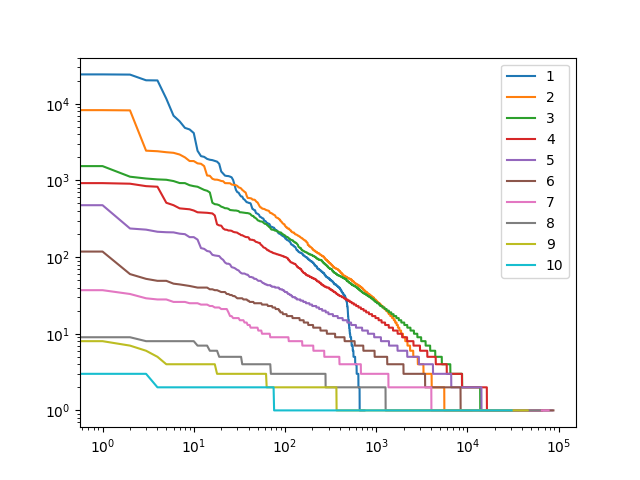

In [11]:
# Cell H
# Zipf's law https://en.wikipedia.org/wiki/Zipf's_law
# Q3: Run this code to produce a plot. What does this plot show? What is on the x-axis, what is on the y-axis?
# Q4: According to this plot, is the ngram assumption justified? If you don't remember what the ngram assumption is, ask Nils.
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

def get_ngram_frequencies(n):
    frequencies = filter(lambda x: len(x[0]) == n, ngram_model.ngrams.items())
    frequencies = map(lambda x: x[1], frequencies)
    y = sorted(frequencies, reverse = True)
    x = np.arange(len(y))
    if len(x) == 0:
        return None, None
    else:
        return x, y

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
for n in range(1,11):
    x, y = get_ngram_frequencies(n)
    if x is None:
        continue
    ax.plot(x, y, label=n)
ax.legend()
plt.show()

In [14]:
display_answer(
    "Q3",
    "The plot shows the frequency of n-grams in the dataset. The x-axis represents the rank of the n-grams, and the y-axis represents the frequency of the n-grams."
)
display_answer(
    "Q4",
    "The plot shows that the ngram assumption may not be justified in our dataset, as the frequencies of n-grams do not follow a Zipf's law distribution (we don't see straight lines in the log-log plot)."
)

In [18]:
# Cell I
# Perplexity
from tqdm import tqdm
def dataset_perplexity(model, data, progress=False, details=False):
    output = 0
    samples = [] if details else None
    it = tqdm(data) if progress else data
    for sentence in it:
        perplexity_ = model.perplexity(sentence)
        output += perplexity_
        if samples is not None:
            samples.append((sentence, perplexity_))
    output /= len(data)
    if details:
        return output, sorted(samples, key=lambda x: x[1])
    else:
        return output
# Q5: Why does this throw an error?
perplexity = dataset_perplexity(ngram_model, tokens['dev'])

AssertionError: ['<bos>', 'liam', 'hoped', 'that', 'a', 'box']: 0

In [21]:
display_answer(
    "Q5",
    "The error occurred because the <code>NgramCounter</code> was initialized without smoothing, which caused some n-grams to have a probability of zero."
)

In [22]:
# Cell J
# Try again, but with "smoothing = 1"
# "smoothing" adds counts to unknown ngrams. No probability is equal to 0 anymore,
# but we give probability mass away that could be used for known ngrams.
ngram_model = NgramCounter(25, smoothing=1)
fit(ngram_model, tokens['train'])
perplexity = dataset_perplexity(ngram_model, tokens['dev'], progress=True)
print(perplexity)

100%|██████████| 3000/3000 [01:25<00:00, 35.21it/s]

5.034350787496002


In [23]:
# Cell K
# small grid search: find the best possible length for ngrams, and the best possible smoothing value
# while this runs, get up and stretch your legs
import itertools
n_values = [1,2,3,4]
smoothing_values = [1,2,4]
params = list(itertools.product(*[n_values, smoothing_values]))
for param in itertools.product(*[n_values, smoothing_values]):
    n, smoothing = param
    ngram_model = NgramCounter(n, smoothing=smoothing)
    fit(ngram_model, tokens['train'])
    perplexity = dataset_perplexity(ngram_model, tokens['dev'])
    print('n={}, smoothing={}, perplexity={}'.format(n, smoothing, perplexity))
# Q6: Why doesn't the dev perplexity keep decreasing as n increases?

n=1, smoothing=1, perplexity=3.945324735268181
n=1, smoothing=2, perplexity=3.9457556107640963
n=1, smoothing=4, perplexity=3.946914983054919
n=2, smoothing=1, perplexity=2.8664946354863146
n=2, smoothing=2, perplexity=3.017926706992085
n=2, smoothing=4, perplexity=3.2023672810157295
n=3, smoothing=1, perplexity=3.5740829970905956
n=3, smoothing=2, perplexity=3.838071246341628
n=3, smoothing=4, perplexity=4.11857556451489
n=4, smoothing=1, perplexity=4.227705632549121
n=4, smoothing=2, perplexity=4.45331717241929
n=4, smoothing=4, perplexity=4.673877224641809


In [ ]:
display_answer(
    "Q6",
    "The perplexity doesn't keep decreasing as n increases because the model becomes more complex and starts to overfit the training data."
)

In [24]:
# Cell L
# Q7: What are the best values for n and smoothing?
best_n = 2
best_smoothing = 1
# Q8: How many parameters does the best ngram model have? Explain how you compute this quantity.
best_ngram_model = NgramCounter(best_n, smoothing=best_smoothing)
fit(best_ngram_model, tokens['train'])

In [32]:
display_answer(
    "Q7",
    f"The best values for n and smoothing are {best_n} and {best_smoothing}, respectively."
)
display_answer(
    "Q8",
    [
        f"The best ngram model has {len(best_ngram_model.ngrams):,d} parameters.".replace(",", " "),
        "We can compute it by counting the number of unique n-grams in the training data because each n-gram has a parameter associated with it."
    ]
)

In [33]:
# Cell M
# Build the best model on train and dev using the parameters for n and smoothing found in cell L.
# Then compute its perplexity on test and gen.
# Q9: What do you notice?
best_n = 2
best_smoothing = 1
ngram_model = NgramCounter(best_n, smoothing=best_smoothing)
fit(ngram_model, tokens['train']+tokens['dev'])
for split in ['train', 'dev', 'test', 'gen']:
    perplexity = dataset_perplexity(ngram_model, tokens[split], progress=True)
    print('{}: {}'.format(split, perplexity))

100%|██████████| 24155/24155 [00:16<00:00, 1494.61it/s]


train: 2.8175040322146168


100%|██████████| 3000/3000 [00:02<00:00, 1496.23it/s]


dev: 2.804659967615997


100%|██████████| 3000/3000 [00:02<00:00, 1391.26it/s]


test: 2.835451687996139


100%|██████████| 21000/21000 [00:14<00:00, 1443.98it/s]

gen: 3.770502495632339


In [34]:
display_answer(
    "Q9",
    "We notice that the perplexity on the 'gen' split is higher compared to the other splits, indicating that the model is not generalizing as well. It may be due to differences in the data distribution between the 'gen' split and the other splits, because perplexity on other splits don't show overfitting."
)

In [44]:
# Cell N
# RNN LM
# Q10: How does this RNN LM deal with words outside of its vocabulary?
import torch
from torch import nn
import itertools

# redefine this helper class
class Vocabulary:
    def __init__(self, words=set()):
        self.vocab = set(words)
        self.unk = '<unk>'
        self.bos = '<bos>'
        self.eos = '<eos>'
        self.vocab.add(self.unk)
        self.vocab.add(self.bos)
        self.vocab.add(self.eos)
        self.vocab = sorted(self.vocab)
        
    def add(self, word):
        if word not in self.vocab:
            self.vocab.append(word)
        
    def process(self, sentence):
        assert isinstance(sentence, list) or isinstance(sentence, tuple)
        assert all(isinstance(x, str) for x in sentence)
        for word in sentence:
            self.add(word)
        
    def size(self):
        return len(self.vocab)

    def word_to_int(self, word):
        assert isinstance(word, str)
        if word in self.vocab:
            key = word
        else:
            key = self.unk
        return self.vocab.index(key)

    def sentence_to_int(self, sentence):
        output = [None for _ in sentence]
        for ii, token in enumerate(sentence):
            output[ii] = self.word_to_int(token)
        return output
        
class RNNLM(nn.Module):
    def __init__(self, vocab=None, n_layers=2, n_units=512):
        super(RNNLM, self).__init__()
        assert isinstance(n_layers, int)
        assert n_layers > 0
        self.n_layers = n_layers
        assert isinstance(n_units, int)
        assert n_units > 0
        self.n_units = n_units
        assert isinstance(vocab, Vocabulary)
        self.vocab = vocab
        self.padding = self.vocab.size()
        # model parameters
        # dense word embeddings
        self.embeddings = nn.Embedding(self.vocab.size()+1, self.n_units, padding_idx=self.padding)
        # recurrent neural network
        self.rnn = nn.LSTM(self.n_units, self.n_units, num_layers=self.n_layers, batch_first=True)
        # final projection layer
        self.projection = nn.Sequential(
            nn.Linear(self.n_units, self.vocab.size()),
            nn.LogSoftmax(2)
        )

    def forward(self, batch):
        assert isinstance(batch, list), batch
        assert all(isinstance(x, list) for x in batch), batch
        assert all(all(isinstance(x, str) for x in sentence) for sentence in batch)
        assert all(x[0] == self.vocab.bos for x in batch)
        assert all(x[-1] == self.vocab.eos for x in batch)        
        # turn into indices
        indices = [self.vocab.sentence_to_int(x) for x in batch]
        # pad
        max_len = max(len(x) for x in indices)
        indices = [x if len(x) == max_len else x+[self.padding]*(max_len-len(x)) for x in indices]
        # turn into tensor
        indices = torch.tensor(indices)
        # feed through model
        word_embeddings = self.embeddings(indices)
        rnn_outputs, _ = self.rnn(word_embeddings)
        logits = self.projection(rnn_outputs)
        return logits, indices

    def perplexity(self, sentence):
        assert isinstance(sentence, list), sentence
        assert all(isinstance(x, str) for x in sentence)
        assert sentence[0] == self.vocab.bos, sentence
        assert sentence[-1] == self.vocab.eos, sentence
        logits, indices = self.forward([sentence])
        logits = logits[0,:-1,:]
        indices = indices[0,1:]
        # there is probably a better way for the following
        perplexity = 0
        for tt, index in enumerate(indices.numpy().tolist()):
            perplexity += logits[tt,index].item()
        perplexity = -perplexity/len(sentence)
        return perplexity

    def batch_perplexity(self, batch):
        assert isinstance(batch, list), batch
        assert all(isinstance(x, list) for x in batch), batch
        assert len(batch) > 0
        perplexities = [ self.perplexity(sentence) for sentence in batch ]
        return sum(perplexities)/len(perplexities)
            
    def number_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class Trainer:
    def __init__(self, model, data, batch_size=128):
        self.model = model
        self.data = data
        self.optimizer = torch.optim.Adam(self.model.parameters())
        assert isinstance(batch_size, int)
        assert batch_size>0
        self.batch_size = batch_size
        self.loss_function = nn.CrossEntropyLoss(ignore_index=self.model.padding, size_average=True)

    def step(self, split, position, grad=False):
        start = position
        end = min(start + self.batch_size, len(self.data[split]))
        batch = self.data[split][start:end]
        logits, indices = self.model.forward(batch)
        targets = indices[:,1:]
        logits = logits[:,:-1,:]
        assert logits.size(0) == targets.size(0)
        assert logits.size(1) == targets.size(1)
        logits = torch.reshape(logits, (-1, self.model.vocab.size()))
        targets = torch.reshape(targets, (-1,))
        loss = self.loss_function(logits, targets)
        if grad:
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), 5)
            self.optimizer.step()
        return loss

    def train(self, num_epochs, verbose=False):
        for epoch in range(num_epochs):
            train_loss = 0
            num_steps = 0
            it = tqdm(range(0, len(self.data['train']), self.batch_size)) if verbose \
                else range(0, len(self.data['train']), self.batch_size)
            for position in it:
                loss_ = self.step('train', position, grad=True)
                train_loss += loss_.item()
                num_steps += 1
            train_loss /= num_steps
            dev_loss = 0
            num_steps = 0
            it = tqdm(range(0, len(self.data['dev']), self.batch_size)) if verbose \
                else range(0, len(self.data['dev']), self.batch_size)
            for position in it:
                loss_ = self.step('dev', position, grad=False)
                dev_loss += loss_
                num_steps += 1
            dev_loss /= num_steps
            print('epoch {}/{}; train loss {}; dev loss {}'.format(epoch+1, num_epochs, train_loss, dev_loss))

In [37]:
display_answer(
    "Q10",
    "The RNN LM deals with words outside of its vocabulary by mapping them to a special '<unk>' token."
)

In [45]:
# Cell O
# Train RNN LM
vocabulary = Vocabulary()
for sentence in tokens['train']:
    vocabulary.process(sentence)
rnn_lm = RNNLM(vocab=vocabulary, n_layers=1, n_units=7)
print(rnn_lm)
print('number of parameters: {}'.format(rnn_lm.number_parameters()))
trainer = Trainer(rnn_lm, tokens)
print('get up and stretch your legs while this runs')
trainer.train(100)
# Q11: How do the number of parameters of this model compare to the number of parameters of the best ngram model?

RNNLM(
  (embeddings): Embedding(745, 7, padding_idx=744)
  (rnn): LSTM(7, 7, batch_first=True)
  (projection): Sequential(
    (0): Linear(in_features=7, out_features=744, bias=True)
    (1): LogSoftmax(dim=2)
  )
)
number of parameters: 11615
get up and stretch your legs while this runs
epoch 1/100; train loss 6.091866962493412; dev loss 5.046941757202148
epoch 2/100; train loss 4.410419655855371; dev loss 4.13668966293335
epoch 3/100; train loss 4.057725382860376; dev loss 3.9980876445770264
epoch 4/100; train loss 3.91999030365515; dev loss 3.855720281600952
epoch 5/100; train loss 3.7844774521217146; dev loss 3.7277815341949463
epoch 6/100; train loss 3.6552150123333806; dev loss 3.595290422439575
epoch 7/100; train loss 3.5147655565271934; dev loss 3.441870927810669
epoch 8/100; train loss 3.3367638840246454; dev loss 3.254112482070923
epoch 9/100; train loss 3.1569398231607266; dev loss 3.0827343463897705
epoch 10/100; train loss 2.997158480699731; dev loss 2.9384686946868896
ep

In [46]:
display_answer(
    "Q11",
    f"The number of parameters of this model is slightly smaller than the number of parameters of the best ngram model. It has {rnn_lm.number_parameters():,d} parameters.".replace(",", " ")
)

In [47]:
# Cell P
# Q12: How does the following compare to the best ngram model?
for split in ['train', 'dev', 'test', 'gen']:
    perplexity = dataset_perplexity(rnn_lm, tokens[split], progress=True)
    print('{}: {}'.format(split, perplexity))

100%|██████████| 24155/24155 [00:13<00:00, 1798.35it/s]


train: 1.843258685676084


100%|██████████| 3000/3000 [00:01<00:00, 1789.82it/s]


dev: 1.8473412793388297


100%|██████████| 3000/3000 [00:01<00:00, 1867.24it/s]


test: 1.8427308465471246


100%|██████████| 21000/21000 [00:13<00:00, 1607.85it/s]

gen: 3.2101710679603115


In [49]:
display_answer(
    "Q12",
    [
        "The perplexity of the RNN LM is lower than that of the best ngram model on all splits, indicating that the RNN LM performs better than the ngram model.",
        "The results are significantly better on the 'train', 'dev' and 'test' splits, but also slightly on 'gen' which suggests that the RNN LM generalizes better than the ngram model."
    ]
)

In [ ]:
# Cell Q
# Note that we underexploited at least 3 things:
# 1. The training time. The dev loss keeps decreasing, even after 200 epochs of training.
# See this by running trainer.train(100)
# 2. The RNN size. This RNN is *tiny* compared to what you'd use in practice. Here we just made it comparable to the best ngram model.
# 3. The data. Once we know at what epoch our RNN converges, we can train on train+dev, using the optimal epoch number as our stopping criterion.
# Q13: What else could we have done to further push the dev loss down?

In [50]:
display_answer(
    "Q13",
    [
        "4. Regularization Techniques: We could implement regularization techniques such as dropout or L2 regularization, in order to limit overfitting in our model.",
        "5. Hyperparameter Tuning: We could also experiment with different hyperparameters (learning rate, batch size, number of layers, ...)"
    ]
)

In [51]:
# Cell R
# Train larger RNN LM
vocabulary = Vocabulary()
for sentence in tokens['train']:
    vocabulary.process(sentence)
rnn_lm_large = RNNLM(vocab=vocabulary, n_layers=2, n_units=512)
print(rnn_lm_large)
print('number of parameters: {}'.format(rnn_lm_large.number_parameters()))
trainer_large = Trainer(rnn_lm_large, tokens)
print('get up and stretch your legs while this runs')
trainer_large.train(5)

RNNLM(
  (embeddings): Embedding(745, 512, padding_idx=744)
  (rnn): LSTM(512, 512, num_layers=2, batch_first=True)
  (projection): Sequential(
    (0): Linear(in_features=512, out_features=744, bias=True)
    (1): LogSoftmax(dim=2)
  )
)
number of parameters: 4965608
get up and stretch your legs while this runs
epoch 1/5; train loss 2.5779025567271723; dev loss 2.0649921894073486
epoch 2/5; train loss 2.03600033313509; dev loss 2.021497964859009
epoch 3/5; train loss 2.011355488388627; dev loss 2.013841152191162
epoch 4/5; train loss 2.0007866419181624; dev loss 2.011286973953247
epoch 5/5; train loss 1.9932712322820432; dev loss 2.010087251663208


In [52]:
# Cell S
# Q14: How does the following compare to the other models?
for split in ['train', 'dev', 'test', 'gen']:
    perplexity = dataset_perplexity(rnn_lm_large, tokens[split], progress=True)
    print('{}: {}'.format(split, perplexity))

100%|██████████| 24155/24155 [01:50<00:00, 218.74it/s]


train: 1.8006862929427256


100%|██████████| 3000/3000 [00:13<00:00, 225.95it/s]


dev: 1.8166657139161784


100%|██████████| 3000/3000 [00:13<00:00, 224.07it/s]


test: 1.8102643273096337


100%|██████████| 21000/21000 [01:45<00:00, 198.58it/s]

gen: 2.966597021900037


In [53]:
display_answer(
    "Q14",
    [
        "The perplexity of the larger RNN LM is quite the same than that of the smaller RNN LM on 'train', 'dev' and 'test' splits",
        "However, the perplexity on the 'gen' split is lower, indicating that the larger RNN LM generalize even better as the smaller RNN LM did."
    ]
)

100%|██████████| 21000/21000 [00:10<00:00, 2005.61it/s]


ngram on gen:
  perplexity: 3.770502495632339
  low perplexity:
    <bos> the girl in a box was given a cake . <eos> -- 1.9547718504713487
    <bos> the donut on the box was eaten by the girl on a table . <eos> -- 2.0409767526976643
    <bos> the donut beside the table was given to emma . <eos> -- 2.32142372733305
    <bos> a girl on the box was lended the balloon beside a table . <eos> -- 2.3282984587208677
    <bos> the cake in the room was given to liam . <eos> -- 2.377783496726387
  high perplexity:
    <bos> charlie awarded matthew a jigsaw . <eos> -- 5.434826022015368
    <bos> charlie brought hazel the weapon . <eos> -- 5.443434029267842
    <bos> lily gave grayson a hedgehog . <eos> -- 5.459891409819
    <bos> david forwarded noah a shark . <eos> -- 5.4757450021315535
    <bos> lily gave grayson a shark . <eos> -- 5.546534807388993


100%|██████████| 3000/3000 [00:01<00:00, 2033.82it/s]


ngram on test:
  perplexity: 2.835451687996139
  low perplexity:
    <bos> a donut was given to emma . <eos> -- 1.5535016266099089
    <bos> the cake was rolled by emma . <eos> -- 1.6013388855308628
    <bos> the cake was rolled . <eos> -- 1.6088758526911702
    <bos> a cake was liked by the girl . <eos> -- 1.6210054267492218
    <bos> the cookie was given to emma . <eos> -- 1.6313994763531092
  high perplexity:
    <bos> joseph studied gabriel . <eos> -- 4.396597636527191
    <bos> mateo lended the princess the flag . <eos> -- 4.484398557443335
    <bos> the monkey served a penguin a leaf beside the baron . <eos> -- 4.503364231821037
    <bos> brooklyn gave a plate beside a machine to bella . <eos> -- 4.560904332255828
    <bos> stella gave david the sweetcorn . <eos> -- 4.998960534214915


100%|██████████| 21000/21000 [00:09<00:00, 2105.31it/s]


rnn on gen:
  perplexity: 3.2101710679603115
  low perplexity:
    <bos> the girl gave a cake on the rock beside a table on a bed to a boy . <eos> -- 1.6584359584921913
    <bos> emma teleported the cake beside a table to the girl . <eos> -- 1.7902598638241984
    <bos> the girl gave a cake on a stage in the house beside a table to a baby . <eos> -- 1.8052162237618177
    <bos> a girl liked that liam liked that a cat hoped that the cookie was adored . <eos> -- 1.8126476936805476
    <bos> a cat teleported the cake beside the table to a girl . <eos> -- 1.815169229408119
  high perplexity:
    <bos> elijah passed lina to sofia . <eos> -- 6.329251224560721
    <bos> mia slipped lina to a fish . <eos> -- 6.430815254076151
    <bos> oliver slipped lina to caleb . <eos> -- 6.470261955302703
    <bos> paula loved to run . <eos> -- 6.815376508344863
    <bos> paula loved to talk . <eos> -- 7.197095988073021


100%|██████████| 3000/3000 [00:01<00:00, 2379.56it/s]


rnn on test:
  perplexity: 1.8427308465471246
  low perplexity:
    <bos> a cake was given to emma by the girl . <eos> -- 0.8720754918225188
    <bos> a cake was liked by the girl . <eos> -- 0.8858712126020691
    <bos> the cake was given to a boy by a girl . <eos> -- 0.9106264383926128
    <bos> the cake was rolled by emma . <eos> -- 0.9216514491021776
    <bos> a cake was lended to emma by the girl . <eos> -- 0.9285156899337986
  high perplexity:
    <bos> aria crumpled the chicken in the cart beside the stage . <eos> -- 3.139635930096399
    <bos> the chief worshipped aubrey . <eos> -- 3.1532197664969965
    <bos> emma served a block beside the sphere to anthony . <eos> -- 3.2748955241277145
    <bos> samuel was promised the cake beside a gardner by emma . <eos> -- 3.385974250849708
    <bos> joseph studied gabriel . <eos> -- 3.6065002964169253


100%|██████████| 21000/21000 [01:31<00:00, 230.20it/s]


rnn large on gen:
  perplexity: 2.966597021900037
  low perplexity:
    <bos> the girl gave a cake on a stage in the house beside a table to a baby . <eos> -- 1.4029841099050828
    <bos> the girl gave a cake on the rock beside a table on a bed to a boy . <eos> -- 1.4988182809222053
    <bos> a girl fed a box in the room in a cup on the table to the boy . <eos> -- 1.7068311630497193
    <bos> emma teleported a cake in the house to the girl . <eos> -- 1.7188242800201317
    <bos> a cat teleported the cake beside the table to a girl . <eos> -- 1.7292732293821504
  high perplexity:
    <bos> theodore gave claire lina . <eos> -- 5.86390296726105
    <bos> leo rented lincoln paula . <eos> -- 5.889794444395063
    <bos> daniel promised ellie lina . <eos> -- 5.89500592917154
    <bos> jackson slipped zoey lina . <eos> -- 6.038066152466594
    <bos> leo rented lincoln lina . <eos> -- 6.257360069172656


100%|██████████| 3000/3000 [00:11<00:00, 253.77it/s]


rnn large on test:
  perplexity: 1.8102643273096337
  low perplexity:
    <bos> the cake was given to a boy by a girl . <eos> -- 0.8784662530009743
    <bos> a cake was given to emma by the girl . <eos> -- 0.8900936400756715
    <bos> a donut was given to a girl by emma . <eos> -- 0.9329544086000775
    <bos> the cake was frozen by the girl . <eos> -- 0.9449064000735234
    <bos> a cake was liked by the girl . <eos> -- 0.948038620375155
  high perplexity:
    <bos> leah scoffed . <eos> -- 3.087176422183984
    <bos> nora pierced a doll . <eos> -- 3.1170491456640383
    <bos> elijah admired camila . <eos> -- 3.1554177702128072
    <bos> stella gave david the sweetcorn . <eos> -- 3.1566595485037396
    <bos> joseph studied gabriel . <eos> -- 3.9332051007683426


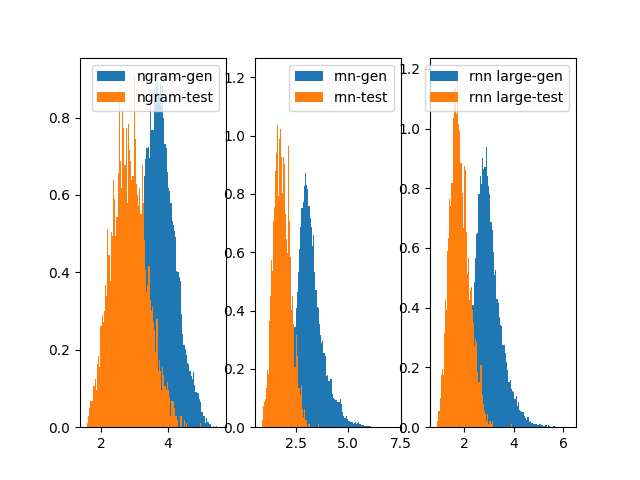

In [54]:
# Cell T
# Look at some high and low perplexity samples
# Look at overall distribution of perplexity
# Q15: What do you notice? Is there a phrase that describes this mismatch between distributions?
fig, ax = plt.subplots(1,3)
for ii, (name, model) in enumerate([('ngram', ngram_model), ('rnn', rnn_lm), ('rnn large', rnn_lm_large)]):
    for split in ['gen', 'test']:
        perplexity, samples = dataset_perplexity(model, tokens[split], progress=True, details=True)
        print('{} on {}:'.format(name, split))
        print('  perplexity: {}'.format(perplexity))
        print('  low perplexity:')
        low_p = ('    '+' '.join(x[0]) + ' -- {}'.format(x[1]) for x in samples[:5])
        print('\n'.join(low_p))
        print('  high perplexity:')
        high_p = ('    '+' '.join(x[0]) + ' -- {}'.format(x[1]) for x in samples[-5:])
        print('\n'.join(high_p))
        y = sorted((x[1] for x in samples), reverse=True)
        assert all(z>0 for z in y)
        x = np.arange(len(y))
        #ax.plot(x, y, label='{}-{}'.format(name,split))
        ax[ii].hist(y, bins=100, density=True, label='{}-{}'.format(name,split))
for ii,_ in enumerate(ax):
    ax[ii].legend()

In [55]:
display_answer(
    "Q15",
    [
        "We notice that sentences with low perplexity are generally simpler and follow common patterns, while sentences with high perplexity are more complex or contain rare words, making them harder for the models to predict accurately.",
        "The mismatch between distributions can be described as a domain shift, where the 'test' data and the 'gen' data come from different distributions, leading to poorer model performance on the 'gen' data that is not well-represented by the training data."
    ]
)